In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import GridSearchCV, KFold
from sklearn import pipeline, svm, linear_model, base, ensemble, preprocessing

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline

## Load the data

In [2]:
train_df = pd.read_csv("train.csv", index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv('test.csv', index_col='PassengerId')
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Initial data check

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<Axes: title={'center': 'Port of Embarkation'}>

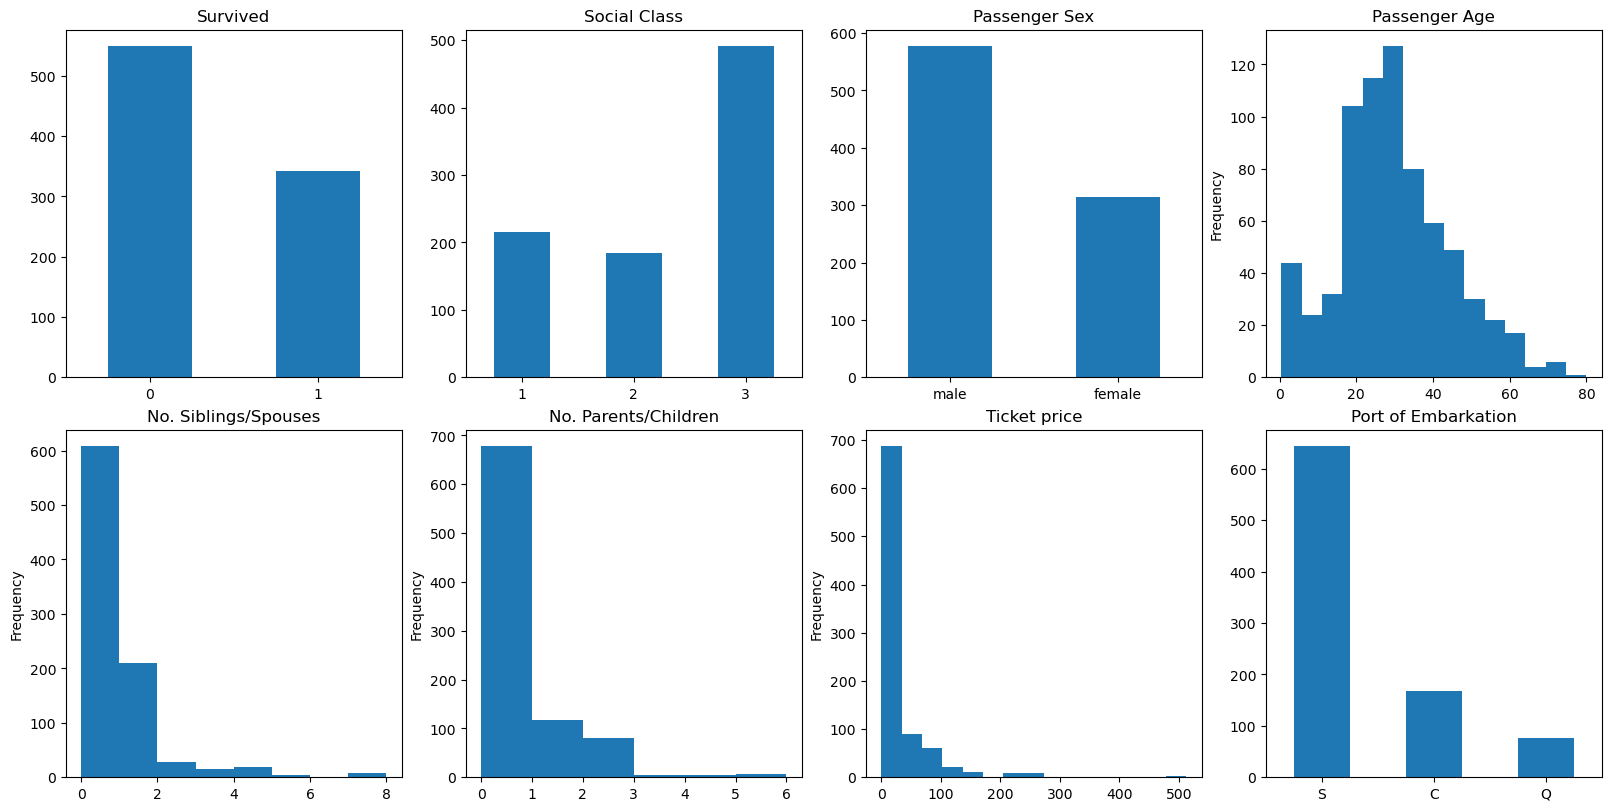

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, layout='constrained')
fig.set_size_inches(16, 8)

train_df['Survived'].value_counts().plot(kind='bar', title='Survived', rot=0, ax=axs[0, 0])
train_df['Pclass'].value_counts().sort_index().plot(kind='bar', title='Social Class', rot=0, ax=axs[0, 1])
train_df['Sex'].value_counts().plot(kind='bar', rot=0, title='Passenger Sex', ax=axs[0, 2])
train_df['Age'].plot(kind='hist', bins=15, title='Passenger Age', ax=axs[0, 3])
train_df['SibSp'].plot(kind='hist', bins=8, title='No. Siblings/Spouses', ax=axs[1, 0])
train_df['Parch'].plot(kind='hist', bins=6, title='No. Parents/Children', ax=axs[1, 1])
train_df['Fare'].plot(kind='hist', bins=15, title='Ticket price', ax=axs[1, 2])
train_df['Embarked'].value_counts().plot(kind='bar', title='Port of Embarkation', rot=0, ax=axs[1, 3])

## Handle missing values

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
# We have missing values for the following columns: Age, Cabin, Embarked

train_df['Age'].isna().mean(), train_df['Cabin'].isna().mean(), train_df['Embarked'].isna().sum()

(0.19865319865319866, 0.7710437710437711, 2)

### Fill the missing values for Embarked

In [8]:
train_df[train_df['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
train_df.loc[train_df['Embarked'].isna(), 'Embarked'] = 'S'
train_df[train_df['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


### Transform the dataset

In [10]:
def transform_dataset(df):
    df_copy = df.copy()

    # Convert "Sex" to Categorical
    df_copy['Sex'] = df_copy['Sex'].map(lambda x: 0 if x == 'female' else 1).astype(np.uint8)

    # Convert 'Embarked' to categorical
    embarked_dummies = pd.get_dummies(df_copy['Embarked'])
    df_copy.drop(columns=['Embarked'], inplace=True)

    for col in embarked_dummies.columns:
        df_copy[col] = embarked_dummies[col]

    # Convert 'Fare' to nullable float
    df_copy['Fare'] = (np.round(df_copy['Fare'])).astype('Float32')

    # Convert 'Age' to integer values
    df_copy['Age'] = np.floor(df_copy['Age']).astype('Int32')

    return df_copy

Transform the categorical variables so we can use them for imputing the missing Age values.

In [11]:
final_train_df = transform_dataset(train_df)
final_train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.0,NaN,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.0,C85,1,0,0
3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.0,C123,0,0,1
5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0,NaN,0,0,1


### Handle missing 'Age' values

In [12]:
final_train_df.corrwith(final_train_df['Age'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.286692
Parch       0.200231
SibSp       0.142508
Fare        0.094681
Sex         0.068482
Survived    0.042841
Q           0.028616
C           0.021645
S           0.006741
dtype: float64

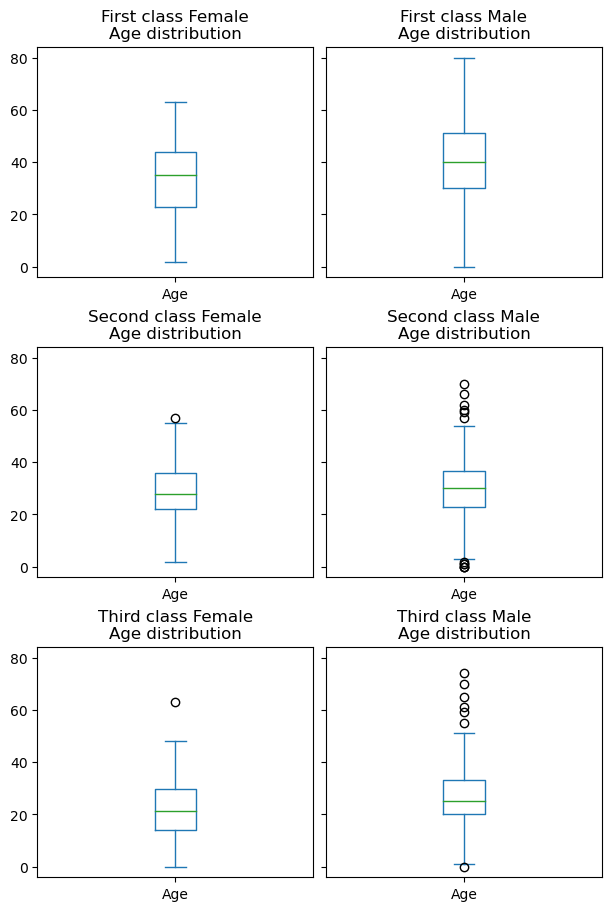

In [13]:
# Plot the Age distribution of Sex w. r. t. the Passenger class

fig, axs = plt.subplots(nrows=3, ncols=2, sharey=True, layout='constrained')

fig.set_size_inches(6, 9)

p_class = [0, 0, 1, 1, 2, 2]
sex = [1, 0, 1, 0, 1, 0]

class_desc = ['First', 'Second', 'Third']
sex_desc = ['Female', 'Male']

for class_id, sex_id in zip(p_class, sex):
    final_train_df.loc[(final_train_df['Pclass'] == (class_id + 1)) & (final_train_df['Sex'] == sex_id), 'Age']\
        .plot(kind='box', ax=axs[class_id, sex_id], title=f'{class_desc[class_id]} class {sex_desc[sex_id]}\nAge distribution')

The 'Age' attribute is correlated with several other attributes such as 'PClass', 'Parch', and 'SibSp' so it could be MAR, also, there's only ~20% missing data so we can safely impute the missing ones.

In [14]:
def get_imputer(df, imputing_columns, **imputer_kwargs):
    train_df_copy = df[imputing_columns]
    imputer = IterativeImputer(max_iter=10, random_state=0, **imputer_kwargs, sample_posterior=True)
    imputer.fit(train_df_copy)
    
    return imputer


def fill_missing(df, imputer, imputing_columns, col_to_fill, missing_val=np.nan):
    partial_df = df[imputing_columns]
    col_idx = imputing_columns.index(col_to_fill)
    imputed_values = imputer.transform(partial_df)
    missing_mask = df[col_to_fill].isna() if missing_val is np.nan else df[col_to_fill] == missing_val
    df.loc[missing_mask, col_to_fill] = imputed_values[missing_mask, col_idx].astype(np.int32)
    df[col_to_fill] = df[col_to_fill].astype(np.int32)

    return df

In [15]:
# Use MICE to handle missing Age values

columns_for_age_imputing = ['Age', 'Pclass', 'Parch', 'SibSp', 'Sex']
age_imputing_params = {
    'initial_strategy':'median',
    'min_value':0,
    'max_value':80
}

age_imputer = get_imputer(final_train_df, columns_for_age_imputing, **age_imputing_params)
final_train_df = fill_missing(final_train_df, age_imputer, columns_for_age_imputing, 'Age')

In [16]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    uint8  
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    Float32
 9   Cabin     204 non-null    object 
 10  C         891 non-null    uint8  
 11  Q         891 non-null    uint8  
 12  S         891 non-null    uint8  
dtypes: Float32(1), int32(1), int64(4), object(3), uint8(4)
memory usage: 67.0+ KB


<Axes: title={'center': 'Passenger Age'}, ylabel='Density'>

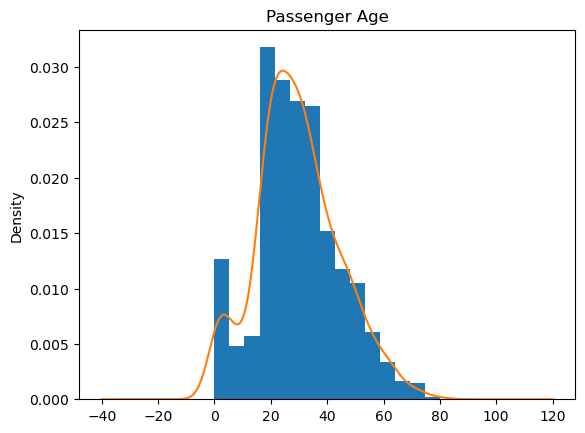

In [17]:
fig, ax = plt.subplots()

final_train_df['Age'].plot(kind='hist', density=True, bins=15, title='Passenger Age', ax=ax)
final_train_df['Age'].plot(kind='kde', ax=ax)

### Handle missing 'Cabin' values

In [18]:
final_train_df.Cabin.isna().mean()

0.7710437710437711

In [19]:
# Let's impute using common sense (for passengers having the same ticket, add the same cabin number)

for id, row in final_train_df[~final_train_df['Cabin'].isna()].iterrows(): # for all rows where cabin not missing
    # take all rows that have same ticket as itself
    # set the same cabins
    same_ticket = final_train_df['Ticket'] == row['Ticket']
    missing_cabin = final_train_df['Cabin'].isna()
    final_train_df.loc[(same_ticket & missing_cabin), 'Cabin'] = row['Cabin']

In [20]:
final_train_df.Cabin.isna().mean()

0.7586980920314254

There are 76% missing value for the 'Cabin' attribute. We have to check if the data is MAR or MCAR to see if we can impute the missing data.

In [21]:
# Identify which type of data missingness we have

missing_cabin = (~final_train_df.Cabin.isna()).astype(np.int32)

final_train_df.corrwith(missing_cabin, method='kendall', numeric_only=True).abs().sort_values(ascending=False)

Pclass      0.671220
Fare        0.483565
Survived    0.331576
C           0.237802
Age         0.209739
Sex         0.160501
Q           0.136111
S           0.122670
Parch       0.072770
SibSp       0.035926
dtype: float64

In [22]:
cabin_missing_by_class_counts = final_train_df.groupby(['Pclass', missing_cabin]).size()
cabin_missing_by_class_counts = cabin_missing_by_class_counts.reset_index()
cabin_missing_by_class_counts = cabin_missing_by_class_counts.pivot(index='Pclass', columns='Cabin', values=0)
cabin_missing_by_class_counts

Cabin,0,1
Pclass,,
1,31,185
2,167,17
3,478,13


In [23]:
table = cabin_missing_by_class_counts.values

chi_val, p_val, dof, expected = stats.chi2_contingency(table)
chi_val, p_val

(592.5649895181917, 2.1190804342104645e-129)

In [24]:
cabin_missing_by_survival_counts  = final_train_df.groupby(['Survived', missing_cabin]).size()
cabin_missing_by_survival_counts = cabin_missing_by_survival_counts.reset_index()
cabin_missing_by_survival_counts = cabin_missing_by_survival_counts.pivot(index='Survived', columns='Cabin', values=0)
cabin_missing_by_survival_counts

Cabin,0,1
Survived,,
0,478,71
1,198,144


In [25]:
table = cabin_missing_by_survival_counts.values

chi_val, p_val, dof, expected = stats.chi2_contingency(table)
chi_val, p_val

(96.37170143528851, 9.521844790105262e-23)

The missing cabin values seem to be correlated with 'Pclass', 'Fare', 'Survived', 'Age', 'Sex' and ports so the data isn't MCAR.  
There's 65% correlation between the passenger Class and the missing Cabin and 31.7% w. r. t. the Survival and these correlations are statistically significant (p < 0.05).
This means that it was harder to retrieve the cabin number for lower class passengers or passengers that didn't survived.

Since the missingness of data is strongly related with other variables we could be dealing with either MAR or MNAR data.

Cabin is in format `{deck}{cabin no.}`  
For most of the Decks the letter is in front of cabin no. except for the Boat Deck where the letter signifies the cabin no.
Since it's harder to impute a representative cabin number we'll focus just on the Deck attribute.

Let's check if the 'Deck' provides any insights on 'Survival'

For passengers that had multiple cabins on different decks, the lowest deck is taken e.g `(F, G) => G`

In [26]:
deck = final_train_df.Cabin.str.split(' ').map(lambda cabins: max([cabin[0] for cabin in cabins]), na_action='ignore')
deck.value_counts(dropna=False)

NaN    676
C       67
B       48
E       33
D       33
A       15
F       11
G        7
T        1
Name: Cabin, dtype: int64

In [27]:
deck.loc[deck == 'T'] = 'A' # convert the cabin for the people in the Boat deck to A deck since only 1st class was occupying it

In [28]:
# Group 'Survived' by survival outcome and 'Deck'
survived_by_deck_counts = final_train_df.Survived.groupby(by=[final_train_df.Survived, deck], dropna=False).count().rename('Count').reset_index()

# Pivot to have the 'Deck' as columns and fill with 0 where no count is present
survived_by_deck_counts = pd.pivot(survived_by_deck_counts, index='Survived', values='Count', columns='Cabin').fillna(0.0)
survived_by_deck_counts.columns.rename('', inplace=True)

survived_by_deck_counts.rename(columns={np.nan: 'M'}, inplace=True)

# Sort the DF by column names, alphabetically
survived_by_deck_counts = survived_by_deck_counts.reindex(sorted(survived_by_deck_counts.columns), axis=1)
survived_by_deck_counts

,A,B,C,D,E,F,G,M
Survived,,,,,,,,
0,9,12,26,8,9,2,5,478
1,7,36,41,25,24,9,2,198


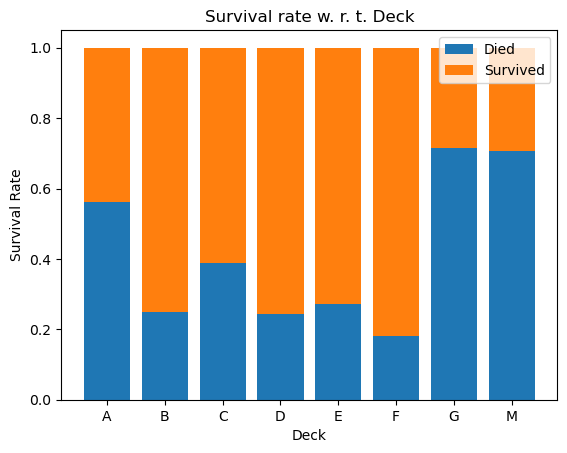

In [29]:
# Normalize the counts to be between [0, 1]
survived_by_deck_counts /= survived_by_deck_counts.sum(axis=0)

bottom = np.zeros_like(survived_by_deck_counts.columns)

fig, ax = plt.subplots()

for val in survived_by_deck_counts.index:
    subset = survived_by_deck_counts.loc[val]
    ax.bar(subset.index, subset.values, bottom=bottom, label='Survived' if val == 1 else 'Died')
    ax.legend()
    bottom += subset.values

ax.set_title('Survival rate w. r. t. Deck')
ax.set_xlabel('Deck')
ax.set_ylabel('Survival Rate')
plt.show()

In [30]:
# Add the "Deck" column to the train_df
final_train_df['Deck'] = deck.fillna(value='M')

final_train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.0,NaN,0,0,1,M
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.0,C85,1,0,0,C
3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,M
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.0,C123,0,0,1,C
5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0,NaN,0,0,1,M


In [31]:
# Encode the Deck column to categorical integers so we can impute it
deck_encode = preprocessing.OrdinalEncoder(encoded_missing_value=-1).fit(final_train_df['Deck'].values.reshape(-1, 1))

print(deck_encode.categories_)

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M'], dtype=object)]


In [32]:
final_train_df['Deck'] = deck_encode.transform(final_train_df['Deck'].values.reshape(-1, 1)).astype(np.int32)
final_train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.0,NaN,0,0,1,7
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.0,C85,1,0,0,2
3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,7
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.0,C123,0,0,1,2
5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0,NaN,0,0,1,7


## Explore correlations

In [33]:
# Plot 1 variable rank-correlation

df_corr = final_train_df.corr(method='kendall', numeric_only=True)
df_corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S,Deck
Survived,1.00,-0.32,-0.54,-0.02,0.09,0.13,0.28,0.17,0.00,-0.15,-0.31
Pclass,-0.32,1.00,0.13,-0.27,-0.04,-0.02,-0.59,-0.21,0.22,0.05,0.66
Sex,-0.54,0.13,1.00,0.07,-0.19,-0.25,-0.23,-0.08,-0.07,0.12,0.15
Age,-0.02,-0.27,0.07,1.00,-0.14,-0.19,0.09,0.04,-0.05,-0.00,-0.21
SibSp,0.09,-0.04,-0.19,-0.14,1.00,0.43,0.37,0.01,-0.05,0.02,-0.03
Parch,0.13,-0.02,-0.25,-0.19,0.43,1.00,0.34,0.02,-0.10,0.04,-0.06
Fare,0.28,-0.59,-0.23,0.09,0.37,0.34,1.00,0.17,-0.16,-0.05,-0.48
C,0.17,-0.21,-0.08,0.04,0.01,0.02,0.17,1.00,-0.15,-0.78,-0.24
Q,0.00,0.22,-0.07,-0.05,-0.05,-0.10,-0.16,-0.15,1.00,-0.50,0.13
S,-0.15,0.05,0.12,-0.00,0.02,0.04,-0.05,-0.78,-0.50,1.00,0.13


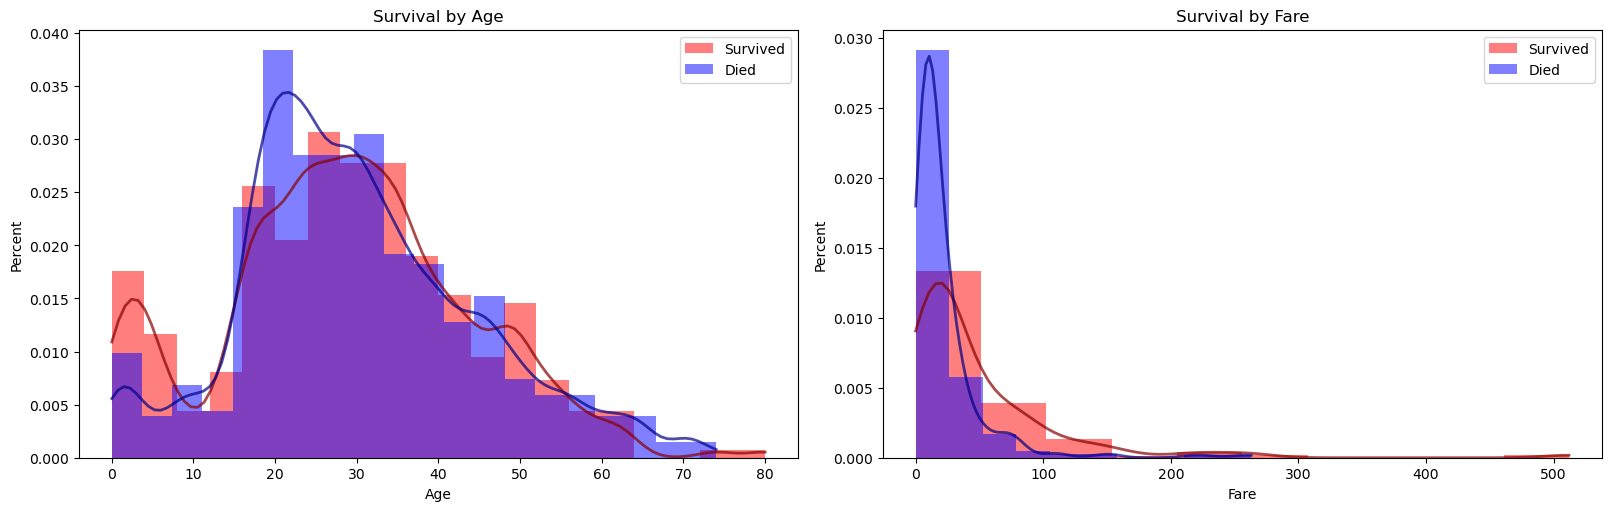

In [34]:
# Plot correlation of continous features

fig, (ax1, ax2) = plt.subplots(ncols=2, layout='constrained')
fig.set_size_inches(16, 5)

age_survived = final_train_df[final_train_df.Survived == 1].Age
age_died = final_train_df[final_train_df.Survived == 0].Age

ax1.hist(age_survived, bins=20, density=True, color='#ff0000', alpha=.5, label='Survived')
x = np.linspace(age_survived.min(), age_survived.max(), 100)
density = stats.gaussian_kde(age_survived, bw_method=.15)
ax1.plot(x, density(x), color='#880000', linewidth=2, alpha=.7)

ax1.hist(age_died, bins=20, density=True, color='#0000ff', alpha=.5, label='Died')
x = np.linspace(age_died.min(), age_died.max(), 100)
density = stats.gaussian_kde(age_died, bw_method=.15)
ax1.plot(x, density(x), color='#000088', linewidth=2, alpha=.7)

ax1.legend()
ax1.set_xlabel('Age')
ax1.set_ylabel('Percent')
ax1.set_title('Survival by Age')

fare_survived = final_train_df[final_train_df.Survived == 1].Fare
fare_died = final_train_df[final_train_df.Survived == 0].Fare

ax2.hist(fare_survived, bins=10, density=True, color='#ff0000', alpha=.5, label='Survived')
x = np.linspace(fare_survived.min(), fare_survived.max(), 100)
density = stats.gaussian_kde(fare_survived.astype(np.float32), bw_method=.3)
ax2.plot(x, density(x), color='#880000', linewidth=2, alpha=.7)

ax2.hist(fare_died, bins=10, density=True, color='#0000ff', alpha=.5, label='Died')
x = np.linspace(fare_died.min(), fare_died.max(), 100)
density = stats.gaussian_kde(fare_died.astype(np.float32), bw_method=.3)
ax2.plot(x, density(x), color='#000088', linewidth=2, alpha=.7)

ax2.legend()
ax2.set_xlabel('Fare')
ax2.set_ylabel('Percent')
ax2.set_title('Survival by Fare')

plt.show()

In [35]:
# TODO
# Plot correlation of categorical features (Pclass, Sex, Deck)

## Feature Engineering

Extract the titles from the passenger names.  
Some of the titles are synonymous to eachother. Below is an explanation of the ones that aren't functional titles (like Major, Dr, Rev)

Don == Mr (title used for men, in titanic for ages 11-80)  
Mlle == Miss (unmarried woman)  
Mme, Dona == Mrs (married woman)  
Master (title used for children till 12)  
Ms (unknown marital status)  
Jonkheer - young lord (unmarried man)

In [36]:
def process_passenger_names(df):
    # Extract into separate columns the following
    # Last Name, Title, First Name, skip the dot after the Title
    name_parts = df['Name'].str.extractall(r'(.*),([^.]+)\.?(.*)')
    name_parts.columns = ['LastName', 'Title', 'FirstName']

    # Remove the 'match' index from the df
    name_parts = name_parts.reset_index(level=1, drop=True)

    # Remove the extra whitespace from cols
    for col in name_parts.columns:
        name_parts[col] = name_parts[col].str.strip(' ')

    # Convert the functional titles & synonymous titles to their simpler counterparts
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Dr', 'Rev', 'Major', 'Col', 'Capt', 'Sir', 'Don', 'Jonkheer'], value='Mr')
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Mlle'], value='Miss')
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Mme', 'the Countess', 'Dona'], value='Mrs')

    # The female passenger boarding ship bearing the title 'Ms' was actually married (link: https://www.encyclopedia-titanica.org/titanic-survivor/encarnacion-reynaldo.html)
    # So we can safely convert both to 'Mrs'
    lady_or_ms = name_parts['Title'].map(lambda title: title in ['Lady', 'Ms'])
    name_parts.loc[lady_or_ms, 'Title'] = 'Mrs'
    
    return name_parts

In [37]:
name_parts = process_passenger_names(final_train_df)
name_parts['Title'].value_counts()

Mr        538
Miss      184
Mrs       129
Master     40
Name: Title, dtype: int64

In [38]:
final_train_df = final_train_df.join(name_parts, how='inner')
final_train_df = final_train_df.drop(columns=['Name'])

final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck,LastName,Title,FirstName
PassengerId,,,,,,,,,,,,,,,,
1,0,3,1,22,1,0,A/5 21171,7.0,NaN,0,0,1,7,Braund,Mr,Owen Harris
2,1,1,0,38,1,0,PC 17599,71.0,C85,1,0,0,2,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,1,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,7,Heikkinen,Miss,Laina
4,1,1,0,35,1,0,113803,53.0,C123,0,0,1,2,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,0,3,1,35,0,0,373450,8.0,NaN,0,0,1,7,Allen,Mr,William Henry


In [39]:
# Children (defined as 'Age' <= 14) or has title 'Master'
def create_is_child_feature(df):
    is_child = (df['Age'] <= 14)
    is_child &= (df.Title != 'Mrs')
    is_child |= (df.Title == 'Master')
    is_child = is_child.astype(np.uint8)

    return is_child

is_child = create_is_child_feature(final_train_df)

In [40]:
final_train_df.corrwith(is_child, numeric_only=True, method='kendall').abs().sort_values(ascending=False)

Parch       0.454174
Age         0.439572
SibSp       0.331480
Pclass      0.166134
Fare        0.114776
Deck        0.106396
Sex         0.085977
Survived    0.082748
Q           0.038710
C           0.021724
S           0.005329
dtype: float64

In [41]:
final_train_df['Child'] = is_child
final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck,LastName,Title,FirstName,Child
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,22,1,0,A/5 21171,7.0,NaN,0,0,1,7,Braund,Mr,Owen Harris,0
2,1,1,0,38,1,0,PC 17599,71.0,C85,1,0,0,2,Cumings,Mrs,John Bradley (Florence Briggs Thayer),0
3,1,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,7,Heikkinen,Miss,Laina,0
4,1,1,0,35,1,0,113803,53.0,C123,0,0,1,2,Futrelle,Mrs,Jacques Heath (Lily May Peel),0
5,0,3,1,35,0,0,373450,8.0,NaN,0,0,1,7,Allen,Mr,William Henry,0


In [42]:
# Create family size feature

family_size = final_train_df.Parch + final_train_df.SibSp + 1

final_train_df['FamilySize'] = family_size

final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck,LastName,Title,FirstName,Child,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,1,22,1,0,A/5 21171,7.0,NaN,0,0,1,7,Braund,Mr,Owen Harris,0,2
2,1,1,0,38,1,0,PC 17599,71.0,C85,1,0,0,2,Cumings,Mrs,John Bradley (Florence Briggs Thayer),0,2
3,1,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,7,Heikkinen,Miss,Laina,0,1
4,1,1,0,35,1,0,113803,53.0,C123,0,0,1,2,Futrelle,Mrs,Jacques Heath (Lily May Peel),0,2
5,0,3,1,35,0,0,373450,8.0,NaN,0,0,1,7,Allen,Mr,William Henry,0,1


In [43]:
final_train_df.corrwith(final_train_df['FamilySize'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

FamilySize    1.000000
SibSp         0.812366
Parch         0.753309
Fare          0.423764
Child         0.389143
Sex           0.273327
Age           0.160981
Survived      0.154863
Deck          0.077842
Q             0.077213
Pclass        0.066044
C             0.048343
S             0.006239
dtype: float64

In [44]:
# Create group size feature

group_size = final_train_df.groupby('Ticket').size()
final_train_df['GroupSize'] = final_train_df['Ticket'].map(lambda ticket: group_size[ticket])

final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck,LastName,Title,FirstName,Child,FamilySize,GroupSize
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,1,22,1,0,A/5 21171,7.0,NaN,0,0,1,7,Braund,Mr,Owen Harris,0,2,1
2,1,1,0,38,1,0,PC 17599,71.0,C85,1,0,0,2,Cumings,Mrs,John Bradley (Florence Briggs Thayer),0,2,1
3,1,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,0,0,1,7,Heikkinen,Miss,Laina,0,1,1
4,1,1,0,35,1,0,113803,53.0,C123,0,0,1,2,Futrelle,Mrs,Jacques Heath (Lily May Peel),0,2,2
5,0,3,1,35,0,0,373450,8.0,NaN,0,0,1,7,Allen,Mr,William Henry,0,1,1


In [45]:
final_train_df.corrwith(final_train_df['GroupSize'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

GroupSize     1.000000
FamilySize    0.622291
Parch         0.547052
SibSp         0.529905
Fare          0.513935
Child         0.347653
Sex           0.246300
Deck          0.176712
Survived      0.170929
Pclass        0.147768
Age           0.126905
Q             0.087706
C             0.066490
S             0.003054
dtype: float64

In [46]:
# One-hot encode the title

title_cols = pd.get_dummies(final_train_df['Title'])

final_train_df = final_train_df.join(title_cols)
final_train_df = final_train_df.drop(columns=['Title'])
final_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,...,Deck,LastName,FirstName,Child,FamilySize,GroupSize,Master,Miss,Mr,Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,1,22,1,0,A/5 21171,7.0,NaN,0,...,7,Braund,Owen Harris,0,2,1,0,0,1,0
2,1,1,0,38,1,0,PC 17599,71.0,C85,1,...,2,Cumings,John Bradley (Florence Briggs Thayer),0,2,1,0,0,0,1
3,1,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,0,...,7,Heikkinen,Laina,0,1,1,0,1,0,0
4,1,1,0,35,1,0,113803,53.0,C123,0,...,2,Futrelle,Jacques Heath (Lily May Peel),0,2,2,0,0,0,1
5,0,3,1,35,0,0,373450,8.0,NaN,0,...,7,Allen,William Henry,0,1,1,0,0,1,0


## Create the training datasets

In [47]:
# Create custom scaler to scale multiple columns at the same time

from typing import List

class MultiColumnStandardScaler(base.TransformerMixin):
    """
        Custom scaler that uses StandardScaler to scale only certain columns
        * param: columns - columns to be scaled by StandardScaler
    """
    def __init__(self, columns: List[str]) -> None:
        self.__cols = columns
        self.__scalers = dict()
    
    def fit(self, X, y=None):
        for col in self.__cols:
            scaler = preprocessing.StandardScaler()
            scaler.fit(X[col].values.reshape(-1, 1))
            self.__scalers[col] = scaler

        return self
    
    def transform(self, X):
        new_data = X.copy()
        for col in self.__cols:
            scaler = self.__scalers[col]
            new_data[col] = scaler.transform(X[col].values.reshape(-1, 1))
        return new_data

In [48]:
final_train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'C', 'Q', 'S', 'Deck', 'LastName', 'FirstName', 'Child',
       'FamilySize', 'GroupSize', 'Master', 'Miss', 'Mr', 'Mrs'],
      dtype='object')

In [49]:
# Create train datasets

ycol = 'Survived'
features = final_train_df.columns.difference([ycol, 'Ticket', 'LastName', 'FirstName', 'Cabin'])

x_train = final_train_df[features]
y_train = final_train_df[ycol]

columns_to_scale = ['Fare', 'Age']

In [50]:
x_train

,Age,C,Child,Deck,FamilySize,Fare,GroupSize,Master,Miss,Mr,Mrs,Parch,Pclass,Q,S,Sex,SibSp
PassengerId,,,,,,,,,,,,,,,,,
1,22,0,0,7,2,7.0,1,0,0,1,0,0,3,0,1,1,1
2,38,1,0,2,2,71.0,1,0,0,0,1,0,1,0,0,0,1
3,26,0,0,7,1,8.0,1,0,1,0,0,0,3,0,1,0,0
4,35,0,0,2,2,53.0,2,0,0,0,1,0,1,0,1,0,1
5,35,0,0,7,1,8.0,1,0,0,1,0,0,3,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,27,0,0,7,1,13.0,1,0,0,1,0,0,2,0,1,1,0
888,19,0,0,1,1,30.0,1,0,1,0,0,0,1,0,1,0,0
889,30,0,0,7,4,23.0,2,0,1,0,0,2,3,0,1,0,1


In [51]:
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

## Train models on the training set

In [52]:
# Train logistic regression model

log_regression_params = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

pipe = pipeline.Pipeline(steps=[('scaler', MultiColumnStandardScaler(columns_to_scale)),
                                ('clf', linear_model.LogisticRegression(max_iter=1000))])
search = GridSearchCV(pipe, param_grid=log_regression_params, refit=True, cv=kf)
search.fit(x_train, y_train)

print(f'Best CV score: {search.best_score_:.3f}')
print(search.best_params_)

Best CV score: 0.828
{'clf__C': 1}


In [53]:
round(search.score(x_train, y_train), 4)

0.8316

In [54]:
# Train Support Vector Classifier model with RBF kernel

rbf_params = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

pipe = pipeline.Pipeline(steps=[('scaler', MultiColumnStandardScaler(columns_to_scale)),
                                ('clf', svm.SVC(kernel='rbf'))])
search = GridSearchCV(pipe, param_grid=rbf_params, refit=True, cv=kf, n_jobs=-1)

search.fit(x_train, y_train)

print(f'Best CV score: {search.best_score_:.3f}')
print(search.best_params_)

Best CV score: 0.833
{'clf__C': 10, 'clf__gamma': 0.01}


In [55]:
round(search.score(x_train, y_train), 4)

0.8395

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = list()

for train_ids, val_ids in kf.split(x_train, y_train):
    xtrain = x_train.iloc[train_ids]
    xval = x_train.iloc[val_ids]
    ytrain = y_train.iloc[train_ids]
    yval = y_train.iloc[val_ids]

    clf = ensemble.RandomForestClassifier(criterion='gini', 
                                            n_estimators=1100,
                                            max_depth=5,
                                            min_samples_split=4,
                                            min_samples_leaf=5,
                                            max_features='sqrt',
                                            oob_score=True,
                                            random_state=42,
                                            n_jobs=-1,
                                            verbose=1)
    clf = clf.fit(xtrain, ytrain)
    scores.append(clf.score(xval, yval))

print(round(np.mean(scores), 3))
print(round(np.std(scores), 3))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elaps

0.834
0.026


[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.1s finished


In [57]:
clf = ensemble.RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='sqrt',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)
clf.fit(x_train, y_train)
round(clf.score(x_train, y_train), 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.2s finished


0.835

## Handle missing test data

In [58]:
final_test_df = transform_dataset(test_df)
final_test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",1,34,0,0,330911,8.0,NaN,0,1,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47,1,0,363272,7.0,NaN,0,0,1
894,2,"Myles, Mr. Thomas Francis",1,62,0,0,240276,10.0,NaN,0,1,0
895,3,"Wirz, Mr. Albert",1,27,0,0,315154,9.0,NaN,0,0,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22,1,1,3101298,12.0,NaN,0,0,1


In [59]:
# Inspect how many variables do we have with missing values
final_test_df.isna().sum()

Pclass      0
Name        0
Sex         0
Age        86
SibSp       0
Parch       0
Ticket      0
Fare        1
Cabin     327
C           0
Q           0
S           0
dtype: int64

### Fill the missing 'Fare' variable

In [60]:
# We have a row with missing 'Fare' attribute

final_test_df[final_test_df['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
PassengerId,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",1,60,0,0,3701,<NA>,NaN,0,0,1


In [61]:
# Let's take all the rows that are similar to our row above

mean_fare = final_train_df[
    (final_train_df['Pclass'] == 3)\
        & (final_train_df['Sex'] == 1)\
        & (final_train_df['Age'] > 40)\
        & (final_train_df['S'] == 1)\
        & (final_train_df['SibSp'] == 0)\
        & (final_train_df['Parch'] == 0)]['Fare'].mean()

round(mean_fare, 1)

10.6

In [62]:
final_test_df.loc[1044, 'Fare'] = round(mean_fare, 1)
final_test_df[final_test_df['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S
PassengerId,,,,,,,,,,,,


### Fill the missing 'Age'

In [63]:
final_test_df = fill_missing(final_test_df, age_imputer, columns_for_age_imputing, 'Age')
final_test_df.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin     327
C           0
Q           0
S           0
dtype: int64

### Transform cabin into 'Deck' and fill out the missing values
First impute the missing values by ticket
Then impute the missing values by multiple imputation

In [64]:
for id, row in final_train_df.iterrows(): # for all train rows
    # take all rows from test that have the same ticket and don't have a cabin
    same_ticket = final_test_df['Ticket'] == row['Ticket']
    missing_cabin = final_test_df['Cabin'].isna()

    # and set the same cabin
    final_test_df.loc[(same_ticket & missing_cabin), 'Cabin'] = row['Cabin']

In [65]:
final_test_df.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin     322
C           0
Q           0
S           0
dtype: int64

In [66]:
# Extract 'Deck' from 'Cabin'
test_deck = final_test_df.Cabin.str.split(' ').map(lambda cabins: max([cabin[0] for cabin in cabins]), na_action='ignore')
test_deck.value_counts(dropna=False)

NaN    322
C       37
B       20
D       13
E        9
F        8
A        7
G        2
Name: Cabin, dtype: int64

In [67]:
# Fill all "decks" greater than 'G' with 'A' since they're actually cabins on the Boat deck
test_deck.loc[test_deck > 'G'] = 'A'

# Add 'Deck' as column
final_test_df['Deck'] = test_deck.fillna('M')

# Encode the decks as ordinal
final_test_df['Deck'] = deck_encode.transform(final_test_df['Deck'].values.reshape(-1, 1)).astype(np.int32)

final_test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,S,Deck
PassengerId,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",1,34,0,0,330911,8.0,NaN,0,1,0,7
893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47,1,0,363272,7.0,NaN,0,0,1,7
894,2,"Myles, Mr. Thomas Francis",1,62,0,0,240276,10.0,NaN,0,1,0,7
895,3,"Wirz, Mr. Albert",1,27,0,0,315154,9.0,NaN,0,0,1,7
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22,1,1,3101298,12.0,NaN,0,0,1,7


In [68]:
final_test_df.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin     322
C           0
Q           0
S           0
Deck        0
dtype: int64

### Create the other columns

In [69]:
# Create features from the Passenger names (FirstName, LastName, Title)
name_parts = process_passenger_names(final_test_df)
final_test_df = final_test_df.join(name_parts)

In [70]:
# Create 'Is Child' feature
is_child = create_is_child_feature(final_test_df)
final_test_df['Child'] = is_child

In [71]:
# Create 'GroupSize' feature

group_size = final_test_df.groupby('Ticket').size()
final_test_df['GroupSize'] = final_test_df['Ticket'].map(lambda ticket: group_size[ticket])

In [72]:
# Create 'FamilySize' feature

family_size = final_test_df.Parch + final_test_df.SibSp + 1
final_test_df['FamilySize'] = family_size

In [73]:
# One-hot encode the 'Title'

title_cols = pd.get_dummies(final_test_df['Title'])

final_test_df = final_test_df.join(title_cols)
final_test_df = final_test_df.drop(columns=['Title', 'Name'])

In [74]:
final_test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,C,Q,...,Deck,LastName,FirstName,Child,GroupSize,FamilySize,Master,Miss,Mr,Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,1,34,0,0,330911,8.0,NaN,0,1,...,7,Kelly,James,0,1,1,0,0,1,0
893,3,0,47,1,0,363272,7.0,NaN,0,0,...,7,Wilkes,James (Ellen Needs),0,1,2,0,0,0,1
894,2,1,62,0,0,240276,10.0,NaN,0,1,...,7,Myles,Thomas Francis,0,1,1,0,0,1,0
895,3,1,27,0,0,315154,9.0,NaN,0,0,...,7,Wirz,Albert,0,1,1,0,0,1,0
896,3,0,22,1,1,3101298,12.0,NaN,0,0,...,7,Hirvonen,Alexander (Helga E Lindqvist),0,1,3,0,0,0,1


## Predict on the test data

In [75]:
test_survived = clf.predict(final_test_df[features])

result_df = pd.DataFrame({'PassengerId':final_test_df.index, 'Survived':test_survived})
result_df.head()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.2s finished


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [76]:
result_df.to_csv('./sixth_submission.csv', header=True, index=False) # 77.8%